### Advanced Machine Learning

# Home Exercise #2

Assignment Due: 18/04/21 23:59

Jonathan Schler

In [1]:
student1Name="Matan Mizrachi" # student1 name here
student1ID="207299363" # student1 ID here


student2Name="Ron Yosef" # student2 name here
student2ID="318466711" # student2 ID here

# ********************************************************** #
# This exercise wasnt solved linearly. 
# ********************************************************** #

The goal of this homework is to provide a realistic setting for a machine learning task. Therefore instructions will not specify the exact steps to carry out. Instead, it is part of theassignment to identify promising features, models and preprocessing methods and apply themas appropriate.

The overall goal is to predict whether a specific credit card transaction is fraudulent or not. Please use the data from this dataset provided on Kaggle here:https://www.kaggle.com/kartik2112/fraud-detection. The Kaggle page also contains a description of the dataset. You will use the train set for training the model and test set for validation.

You are free to manipulate the train dataset as you think is appropriate. You do not have to use the wholedataset, you can subsample if you want. While the modelling process is likely iterative, please lay out the  following tasks in the given order to facilitate grading.

## Task 1 Identify Features
Assemble a dataset consisting of features and target (for example in a dataframe or in two arrays X and y). What features are relevant for the prediction task? What features should be excluded because they leak the target information? Show visualizations or statistics to support your selection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
# Pick up from last point of pre processing (should be used for the final product):

def preProcess(x_df: pd.DataFrame, encode=False) -> pd.DataFrame:
    x = x_df.copy()

    as_time = pd.to_datetime(x['unix_time'], unit='s')

    x['zip'] = x['zip'].astype(object)
    x['hour_minute_sec'] = as_time.apply(lambda z: z.hour) + as_time.apply(lambda z: z.minute/60) + as_time.apply(lambda z: z.second/3600)
    x['sub_category'] = x['category'].apply(lambda z: z if len(z.split('_')) == 0 else z.split('_')[-1])
    x['street_name'] = x['street'].apply(lambda z: ' '.join(z.split(' ')[1:]))
    x['street_number'] = x['street'].apply(lambda z: int(z.split(' ')[0]))
    x.drop(columns=['street'], inplace=True)
    
    credit_cards = pd.DataFrame()
    credit_cards['cc_num'] = x['cc_num'].copy()
    
    credit_cards['unix_time'] = x['unix_time']
    credit_cards = credit_cards.iloc[np.argsort(credit_cards['unix_time'])]
    
    credit_cards['diff'] = credit_cards.groupby(by=['cc_num']).diff()['unix_time']
    is_nan = credit_cards.isna()['diff']
    credit_cards.fillna(value=0, inplace=True)
    credit_cards['time_diff'] = pd.to_datetime(credit_cards['diff'], unit='s')
    credit_cards['time_diff'] = credit_cards['time_diff'].apply(lambda z: z.day + z.hour/24 + z.minute/(24*60) + z.second/(24*3600))
    credit_cards.loc[is_nan] = 0
    
    x['time_diff'] = credit_cards['time_diff'].copy()
    
    credit_cards = None
    x = x.drop(columns=['unix_time'], inplace=False)

    categorical = x.dtypes == object
    x.loc[:, categorical] = x.loc[:, categorical].apply(lambda z: z.astype('category'))
    
    if encode:
        x.loc[:, categorical] = x.loc[:, categorical].apply(lambda z: z.cat.codes) 
    
    return x


# redundent.
def openResults() -> pd.DataFrame:
    return pd.read_csv('current_results.csv', index_col=0)

First, let's load the train and test sets. Since the training data and test data are originally separated, we'll assume they are distributed in the same way. 

In [2]:
N = 500 * 10**3

x_train = pd.read_csv('fraudTrain.csv', index_col=0)
y_train = x_train['is_fraud']
x_train.drop(columns=['is_fraud'], inplace=True)

x_test = pd.read_csv('fraudTest.csv', index_col=0)
y_test = x_test['is_fraud']
x_test.drop(columns=['is_fraud'], inplace=True)
x_train.head()

c:\Users\tomda\source\pytho\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459


In [3]:
categorical = x_train.dtypes == object
x_train.loc[:, categorical] = x_train.loc[:, categorical].apply(lambda x: x.astype('category'))
x_test.loc[:, categorical] = x_test.loc[:, categorical].apply(lambda x: x.astype('category'))

In [4]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype   
---  ------                 --------------    -----   
 0   trans_date_trans_time  1296675 non-null  category
 1   cc_num                 1296675 non-null  int64   
 2   merchant               1296675 non-null  category
 3   category               1296675 non-null  category
 4   amt                    1296675 non-null  float64 
 5   first                  1296675 non-null  category
 6   last                   1296675 non-null  category
 7   gender                 1296675 non-null  category
 8   street                 1296675 non-null  category
 9   city                   1296675 non-null  category
 10  state                  1296675 non-null  category
 11  zip                    1296675 non-null  int64   
 12  lat                    1296675 non-null  float64 
 13  long                   1296675 non-null  float64 
 14  ci

Now, let's visualize the data, in order to detect leaky/relevant features.

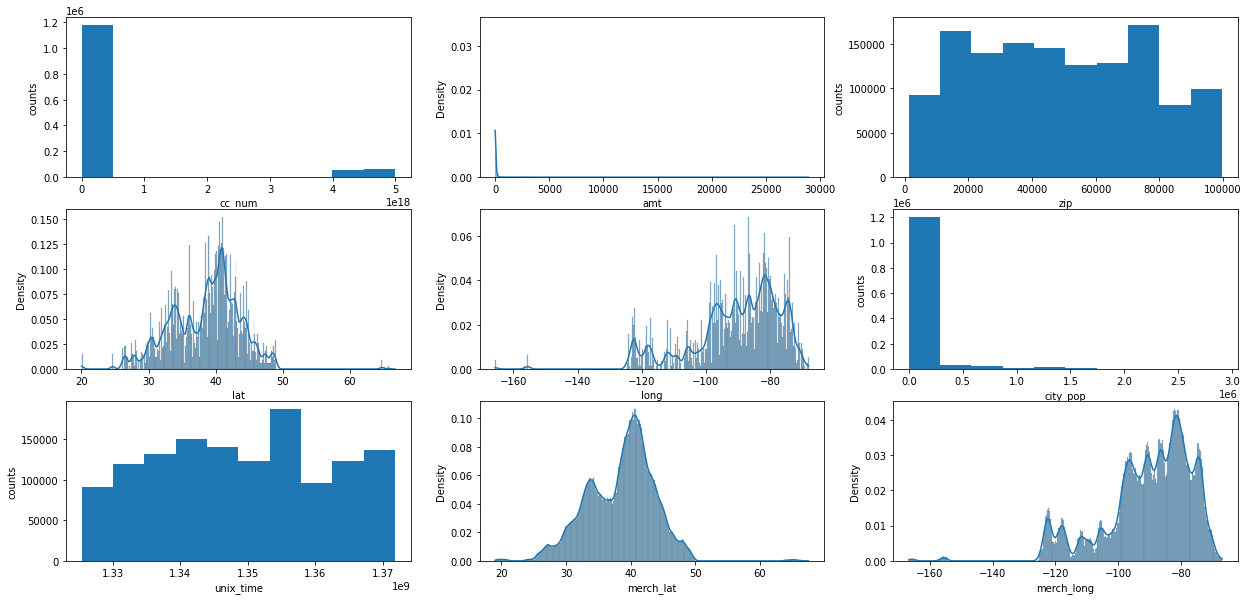

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(21,10))
cols = x_train.columns
i = 0
for c in cols:
    if x_train.dtypes[c] == 'int64':
        axes[i//3,i%3].hist(x_train.loc[x_train[c].isna() == False,c].to_numpy())
        axes[i//3,i%3].set_xlabel(c)
        axes[i//3,i%3].set_ylabel('counts')
        i += 1
    elif x_train.dtypes[c] == 'float64':
        sns.histplot(data=x_train, x=c, discrete=False, ax=axes[i//3,i%3], kde=True, stat='density')
        i+=1

plt.show()

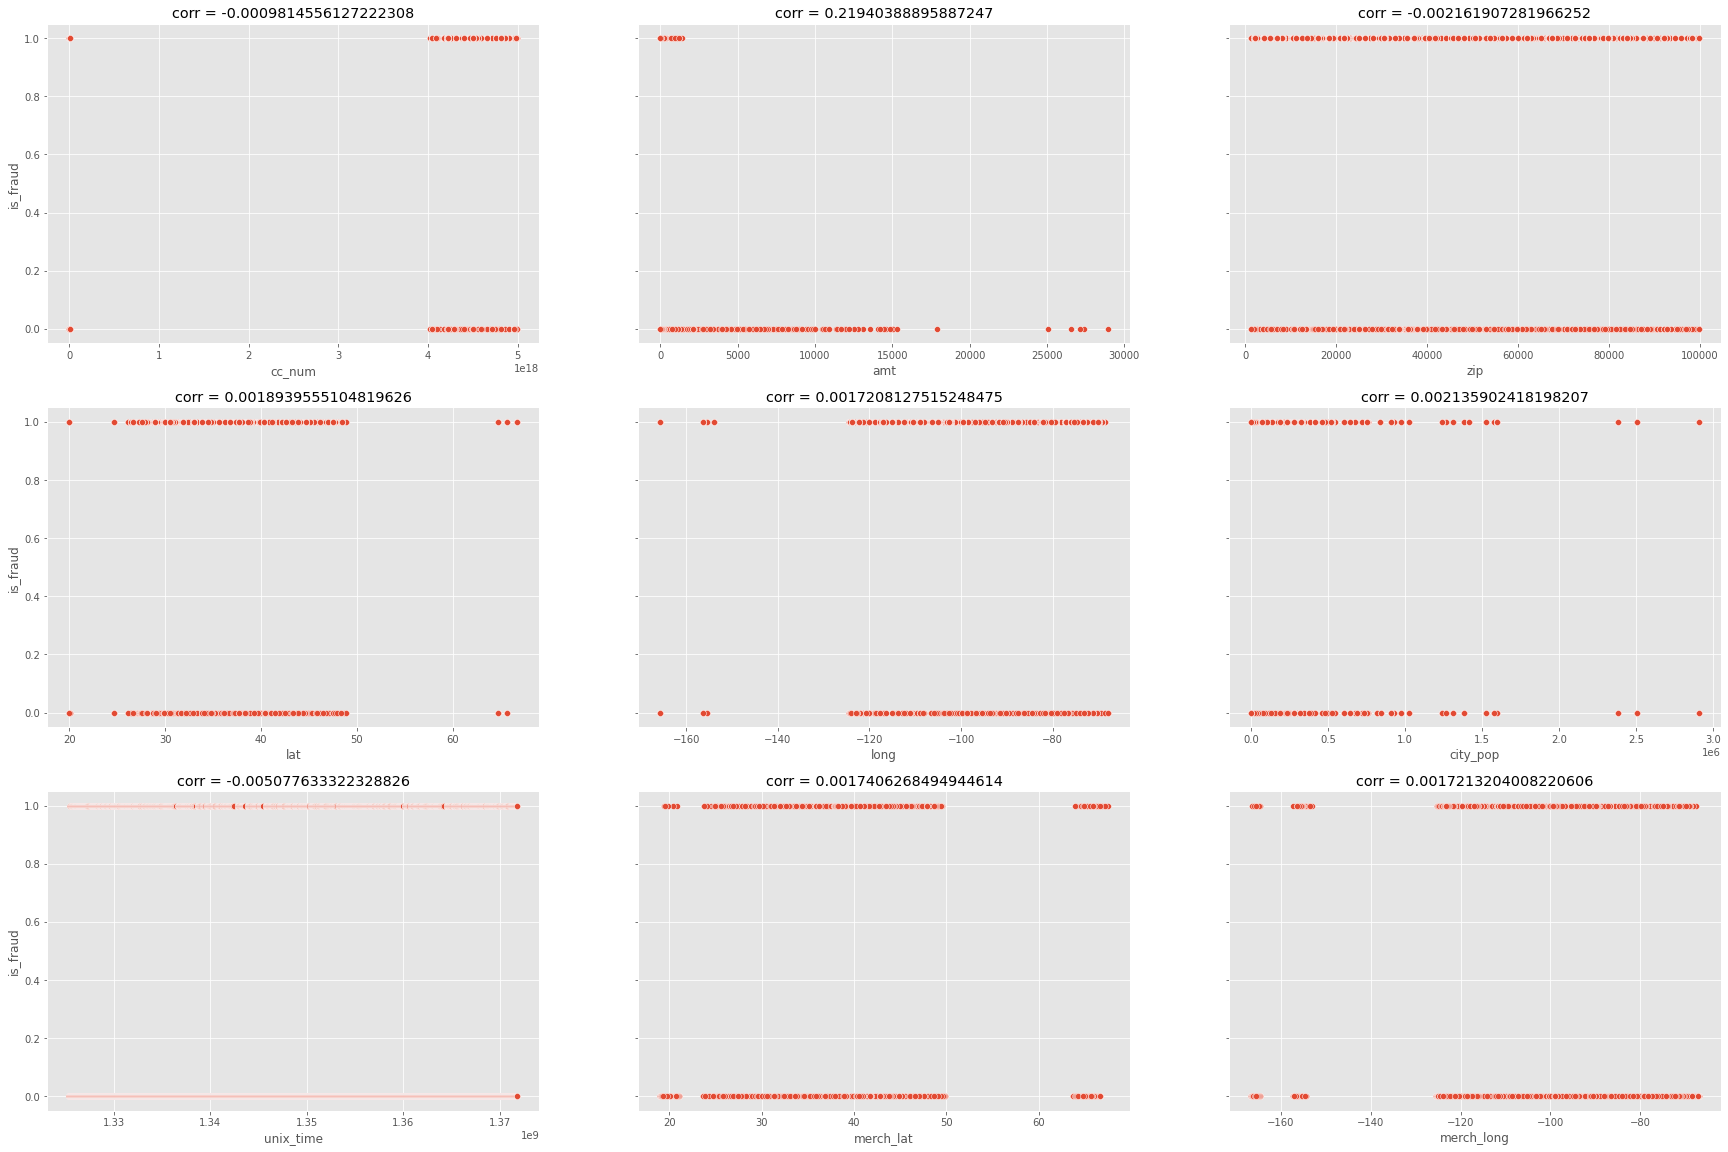

In [6]:
plt.style.use('ggplot')
temp_df = x_train.copy()
temp_df['is_fraud'] = y_train.copy()
corr = temp_df.corr()

fig, axes = plt.subplots(3, 3, figsize=(30,20), sharey=True)
i = 0
for c in cols:
    if x_train.dtypes[c] == 'int64' or x_train.dtypes[c] == 'float64':
        axes[i//3,i%3].set_title(f'corr = {corr.loc[c, "is_fraud"]}')
        sns.scatterplot(x=c, y="is_fraud", data=temp_df, ax=axes[i//3,i%3])
        i += 1

plt.show()
fig = axes = None

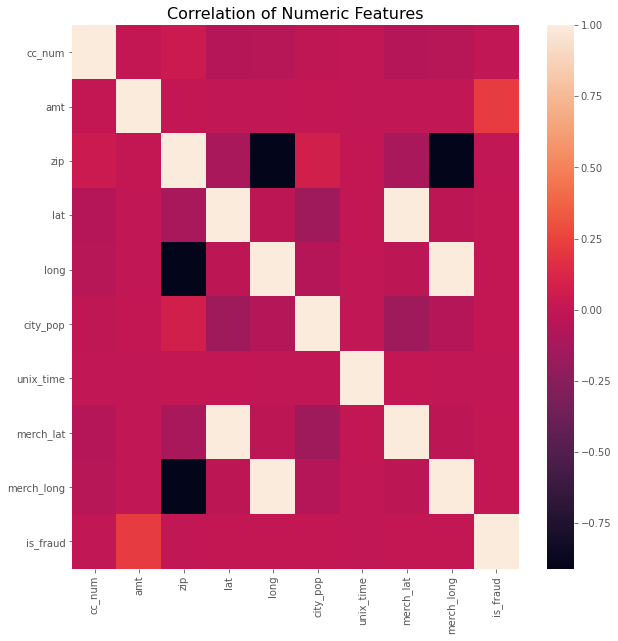

In [7]:
plt.figure(figsize=(10, 10))
plt.title('Correlation of Numeric Features',y=1,size=16)
sns.heatmap(corr, vmax=1, ax=plt.gca())
plt.show()

It is clear that the _long_ feature is very problematic in terms of statistical dependency with other features, as it is highly correlated with the _zip_ and _merch_long_ features. As for the _lat_ feature, which is highly correlated with _merch_lat_. 
Hence, we'd like to give up on these features.

In [8]:
cols = x_train.columns
x_train.drop(columns=['long', 'lat'], inplace=True)
x_test.drop(columns=['long', 'lat'], inplace=True)
cols = cols.drop(['long', 'lat'])
temp_df = None

In [9]:
x_train['zip'] = x_train['zip'].astype('category')
x_test['zip'] = x_test['zip'].astype('category')
categorical = x_train.dtypes == 'category'

Let's try to find the important features:

In [12]:
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest

In [20]:
tx_train: pd.DataFrame = x_train.copy()[:N] # N = 500K
ty_train = y_train.copy()[:N]
#tx_train.loc[:, categorical] =  tx_train.loc[:, categorical].apply(lambda x: x.cat.codes)

In [29]:
temp_df = tx_train.loc[:, categorical].copy().apply(lambda x: x.cat.codes)
scores = SelectKBest(chi2, k='all')
scores.fit(temp_df, ty_train)
temp_df = None

In [33]:
temp_df = pd.DataFrame()
temp_df['column'] = cols[categorical]
temp_df['$\chi^2$'] = scores.scores_
temp_df

,column,$\chi^2$
0,trans_date_trans_time,-4.665765e+10
1,merchant,4.911753e+02
2,category,5.009941e+02
3,first,1.172499e+03
4,last,8.120486e+01
5,gender,2.761882e+00
6,street,2.031113e+02
7,city,6.286474e+02
8,state,7.543995e+01
9,zip,1.151671e+03


In [35]:
scores = SelectKBest(mutual_info_classif, k='all')
temp_df = tx_train.copy()
temp_df.loc[:, categorical] = temp_df.loc[:, categorical].apply(lambda x: x.cat.codes)
scores.fit(temp_df, ty_train)
temp_df = pd.DataFrame()
temp_df['column'] = cols
temp_df['MI'] = scores.scores_
temp_df

,column,MI
0,trans_date_trans_time,0.007064
1,cc_num,0.009756
2,merchant,0.002821
3,category,0.010514
4,amt,0.018030
5,first,0.004339
6,last,0.005106
7,gender,0.025145
8,street,0.010155
9,city,0.009248


Based on the results, it is safe to say that _trans_num_ holds no information regarding the target value, therefore, it is a redundant feature.
As for the others, we'll have to figure out whether those are leaky or informative features.

In [41]:
x_train.drop(columns=['trans_num'], inplace=True)
x_test.drop(columns=['trans_num'], inplace=True)
cols = cols.drop(['trans_num'])
temp_df = None
categorical = x_train.dtypes == 'category'

In [45]:
tx_train = ty_train = None

We'll now take a look on the numeric data's distributions/stats, as this might help us to detect leaky/important features.

In [68]:
from scipy import stats
temp_df = x_train.loc[:, ~categorical].copy()
is_fraud = y_train == 1
temp_df.head()

,cc_num,amt,city_pop,unix_time,merch_lat,merch_long
0,2703186189652095,4.97,3495,1325376018,36.011293,-82.048315
1,630423337322,107.23,149,1325376044,49.159047,-118.186462
2,38859492057661,220.11,4154,1325376051,43.150704,-112.154481
3,3534093764340240,45.00,1939,1325376076,47.034331,-112.561071
4,375534208663984,41.96,99,1325376186,38.674999,-78.632459


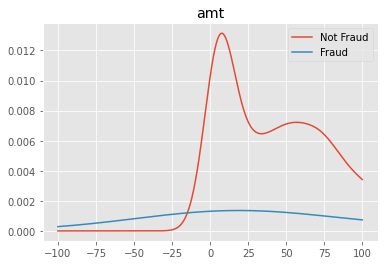

In [66]:
dens = stats.kde.gaussian_kde(temp_df.loc[~is_fraud]['amt'])
x = np.arange(-100, 100, 0.1)
plt.plot(x, dens(x), label='Not Fraud')
dens = stats.kde.gaussian_kde(temp_df.loc[is_fraud]['amt'])
plt.plot(x, dens(x), label='Fraud')
plt.title('amt')
plt.legend()
plt.show()

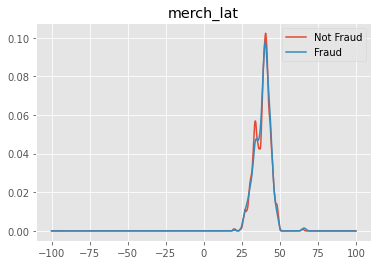

In [69]:
dens = stats.kde.gaussian_kde(temp_df.loc[~is_fraud]['merch_lat'])
x = np.arange(-100, 100, 0.1)
plt.plot(x, dens(x), label='Not Fraud')
dens = stats.kde.gaussian_kde(temp_df.loc[is_fraud]['merch_lat'])
plt.plot(x, dens(x), label='Fraud')
plt.title('merch_lat')
plt.legend()
plt.show()

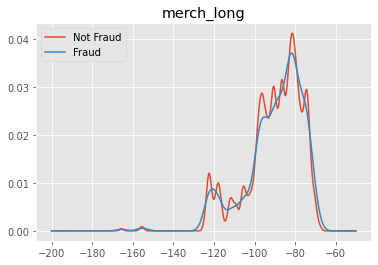

In [71]:
dens = stats.kde.gaussian_kde(temp_df.loc[~is_fraud]['merch_long'])
x = np.arange(-200, -50, 0.1)
plt.plot(x, dens(x), label='Not Fraud')
dens = stats.kde.gaussian_kde(temp_df.loc[is_fraud]['merch_long'])
plt.plot(x, dens(x), label='Fraud')
plt.title('merch_long')
plt.legend()
plt.show()
dens = x = None


In [73]:
pd.concat([temp_df.loc[~is_fraud]['cc_num'].describe(), temp_df.loc[is_fraud]['cc_num'].describe()], axis=1)

,cc_num,cc_num
count,1.289169e+06,7.506000e+03
mean,4.172901e+17,4.003577e+17
std,1.308990e+18,1.276871e+18
min,6.041621e+10,6.041621e+10
25%,1.800429e+14,1.800429e+14
50%,3.521417e+15,3.528041e+15
75%,4.642255e+15,4.651007e+15
max,4.992346e+18,4.992346e+18


In [74]:
pd.concat([temp_df.loc[~is_fraud]['city_pop'].describe(), temp_df.loc[is_fraud]['city_pop'].describe()], axis=1)


,city_pop,city_pop
count,1.289169e+06,7.506000e+03
mean,8.877523e+04,9.727676e+04
std,3.018065e+05,3.265815e+05
min,2.300000e+01,2.300000e+01
25%,7.430000e+02,7.465000e+02
50%,2.456000e+03,2.623000e+03
75%,2.032800e+04,2.143700e+04
max,2.906700e+06,2.906700e+06


In [75]:
pd.concat([temp_df.loc[~is_fraud]['unix_time'].describe(), temp_df.loc[is_fraud]['unix_time'].describe()], axis=1)


,unix_time,unix_time
count,1.289169e+06,7.506000e+03
mean,1.349249e+09,1.348389e+09
std,1.283514e+07,1.383020e+07
min,1.325376e+09,1.325466e+09
25%,1.338759e+09,1.335744e+09
50%,1.349254e+09,1.348872e+09
75%,1.359378e+09,1.360021e+09
max,1.371817e+09,1.371787e+09


In [56]:
temp_df = None

This seems like _amt_ could make an important feature to a predictive model, as the answer to the question "is this Transaction fraudulent?" effects
the data distribution massively.
We also understand that there is a huge difference between the amount of fraudulent variables to non-fraudulent variables. Hence, we'll have to take care of it before we move forward.

In [2]:
!pip install imbalanced-learn

In [11]:
from imblearn.over_sampling import SMOTE

temp_df = x_train.copy()
temp_df.loc[:, categorical] = temp_df.loc[:, categorical].apply(lambda _x: _x.cat.codes)

x_train_new, y_train_new = SMOTE().fit_resample(temp_df, y_train)

In [45]:
x_train_new.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,city_pop,job,dob,unix_time,merch_lat,merch_long
0,0,2703186189652095,514,8,4.97,162,18,0,568,526,27,28654,3495,370,779,1325376018,36.011293,-82.048315
1,1,630423337322,241,4,107.23,309,157,0,435,612,47,99160,149,428,607,1325376044,49.159047,-118.186462
2,2,38859492057661,390,0,220.11,115,381,1,602,468,13,83252,4154,307,302,1325376051,43.150704,-112.154481
3,3,3534093764340240,360,2,45.00,163,463,1,930,84,26,59632,1939,328,397,1325376076,47.034331,-112.561071
4,4,375534208663984,297,9,41.96,336,149,1,418,216,45,24433,99,116,734,1325376186,38.674999,-78.632459


In [17]:
np.unique(y_train_new, return_counts=True)[1]

array([1289169, 1289169], dtype=int64)

In [42]:
New_N = np.append(np.arange(0, 250 * 10 ** 3), np.arange(len(y_train_new) - 250 * 10 ** 3, len(y_train_new)))
np.unique(y_train_new[New_N], return_counts=True)[1]

array([248047, 251953], dtype=int64)

In [54]:
np.sum(x_train_new.copy().isna())

trans_date_trans_time        0
cc_num                       0
merchant                     0
category                     0
amt                          0
first                        0
last                         0
gender                       0
street                       0
city                         0
state                        0
zip                      12893
city_pop                     0
job                          0
dob                          0
unix_time                    0
merch_lat                    0
merch_long                   0
dtype: int64

Now, as could be seen above, the data is balanced, although there are some missing values, and we'd like to take care of that moving forward.

In [64]:
#%%capture
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

temp_df = x_train_new.copy().iloc[New_N, :]
index = ~temp_df['zip'].isna()
cols = x_train.columns
temp_df = temp_df.loc[index]

results = pd.DataFrame(data=[], index=cols)

for i, c in enumerate(cols):
    test_df = temp_df.drop(columns=[c], inplace=False)
    res = cross_validate(RandomForestClassifier(n_estimators=50), test_df, y_train_new[New_N][index], cv=3, scoring = ('accuracy', 'roc_auc', 'average_precision'))
    results.loc[c, ['Accuracy', 'AUC', 'Precision']] = np.array([np.mean(res['test_accuracy']), np.mean(res['test_roc_auc']), np.mean(res['test_average_precision'])])
    
test_df = temp_df = res = index = None

In [65]:
results

,Accuracy,AUC,Precision
trans_date_trans_time,0.574122,0.964177,0.950953
cc_num,0.505272,0.827295,0.779873
merchant,0.505724,0.819507,0.770615
category,0.504988,0.808460,0.765407
amt,0.504876,0.813513,0.766028
first,0.505808,0.787561,0.741517
last,0.505342,0.806197,0.756232
gender,0.505632,0.775023,0.726167
street,0.506283,0.798723,0.753123
city,0.504968,0.822418,0.776244


The thing we tried to do here is to detect leaky features, using a Random Forest Classifier model and a feature dropout, and we couldn't actually find any.
However, we can observe an interesting phenomenon; When _unix_time_ or _trans_date_trans_time_ are being dropped, the AUC rises significantly, only the significance seems to be similar.  

That fact could mean that maybe one of these features is redundent.

In [67]:
pd.concat([pd.to_datetime(x_train['unix_time'], unit='s'), x_train['trans_date_trans_time']], axis=1)

,unix_time,trans_date_trans_time
0,2012-01-01 00:00:18,2019-01-01 00:00:18
1,2012-01-01 00:00:44,2019-01-01 00:00:44
2,2012-01-01 00:00:51,2019-01-01 00:00:51
3,2012-01-01 00:01:16,2019-01-01 00:01:16
4,2012-01-01 00:03:06,2019-01-01 00:03:06
...,...,...
1296670,2013-06-21 12:12:08,2020-06-21 12:12:08
1296671,2013-06-21 12:12:19,2020-06-21 12:12:19
1296672,2013-06-21 12:12:32,2020-06-21 12:12:32
1296673,2013-06-21 12:13:36,2020-06-21 12:13:36


As could be seen, these two features are, in fact, the same, so we might as well just keep one of them.

## Task 2 Preprocessing and Baseline Model

Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model. Feel free to generously exclude features or do simplified preprocessing for this task. As mentioned before, you don’t need to validate the model on the whole dataset

In [1]:
!pip install imbalanced-learn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE

In [4]:
x_train = pd.read_csv('fraudTrain.csv', index_col=0)
y_train = x_train['is_fraud']
x_train.drop(columns=['is_fraud', 'long', 'lat', 'trans_num', 'unix_time'], inplace=True)
x_train.head()

c:\Users\tomda\source\pytho\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,city_pop,job,dob,merch_lat,merch_long
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,3495,"Psychologist, counselling",1988-03-09,36.011293,-82.048315
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,149,Special educational needs teacher,1978-06-21,49.159047,-118.186462
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,4154,Nature conservation officer,1962-01-19,43.150704,-112.154481
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,1939,Patent attorney,1967-01-12,47.034331,-112.561071
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,99,Dance movement psychotherapist,1986-03-28,38.674999,-78.632459


In [3]:
x_train['zip'] = x_train['zip'].astype(object)
categorical = x_train.dtypes == object
x_train.loc[:, categorical] = x_train.loc[:, categorical].apply(lambda x: x.astype('category'))

temp_df = x_train.copy()
temp_df.loc[:, categorical] = temp_df.loc[:, categorical].apply(lambda _x: _x.cat.codes)

x_train_new, y_train_new = SMOTE().fit_resample(temp_df, y_train)
temp_df = None


New_N = np.append(np.arange(0, 50 * 10 ** 3), np.arange(len(y_train_new) - 50 * 10 ** 3, len(y_train_new)))
cols = x_train.columns

The previous blocks was meant to allow us to begin this task, right away, in case of kernel restart, without going through the whole blocks from the first task.
We now want to build our baseline model. 

In [4]:
np.unique(y_train_new[New_N], return_counts=True)[1]

array([49552, 50448], dtype=int64)

In [6]:
x_train = y_train = None
x_train_new = x_train_new.iloc[New_N, :]
y_train_new = y_train_new[New_N]

In [7]:
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

In [8]:
x_train_new.drop(columns=['trans_date_trans_time'], inplace=True)
cols = cols.drop(['trans_date_trans_time'])

Our baseline model is gonna be really "simple". It is gonna be trained over a small percentage of the balanced original training set. The idea is to create a weak model that is able to show us the strengths and downfalls of our data moving forward.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_train_new, y_train_new, test_size=0.3)
x_train_new = y_train_new = None

In [10]:
np.unique(y_train, return_counts=True)[1]

array([34719, 35281], dtype=int64)

In [11]:
%%capture
baseline_model_scaled = cross_validate(make_pipeline(StandardScaler(), LogisticRegression()),  x_train, y_train, cv=10, 
                                       scoring = ('accuracy', 'roc_auc', 'average_precision'))
baseline_model = cross_validate(LogisticRegression(),  x_train, y_train, cv=10, 
                                       scoring = ('accuracy', 'roc_auc', 'average_precision'))

#

In [12]:
results = {'Logistic Regression Scaled': [np.mean(baseline_model_scaled['test_accuracy']), np.mean(baseline_model_scaled['test_roc_auc']), 
                                   np.mean(baseline_model_scaled['test_average_precision'])], 
          'Logistic Regression': [np.mean(baseline_model['test_accuracy']), np.mean(baseline_model['test_roc_auc']), 
                                   np.mean(baseline_model['test_average_precision'])]}

pd.DataFrame(results, index=['Accuracy', 'AUC', 'Precision'])

,Logistic Regression Scaled,Logistic Regression
Accuracy,0.881614,0.495986
AUC,0.916004,0.497709
Precision,0.928417,0.511821


In [13]:
baseline_model_scaled: Pipeline = make_pipeline(StandardScaler(), LogisticRegression())
baseline_model_scaled.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, baseline_model_scaled.predict(x_test), target_names=['Clear','Fraud']))

              precision    recall  f1-score   support

       Clear       0.83      0.95      0.89     14833
       Fraud       0.94      0.81      0.87     15167

    accuracy                           0.88     30000
   macro avg       0.89      0.88      0.88     30000
weighted avg       0.89      0.88      0.88     30000



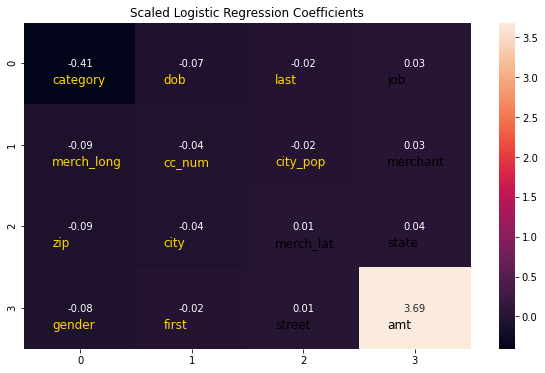

In [15]:
plt.figure(figsize=(10 ,6))
plt.xticks([])
plt.yticks([])
coef = baseline_model_scaled.named_steps['logisticregression'].coef_.copy()
x = np.array(cols, dtype=object)
x = x[coef.argsort()]
coef.sort()
coef = coef.reshape(4, 4)
x = x.reshape(4, 4)
sns.heatmap(coef.T, annot=True, fmt=".2f").set_title("Scaled Logistic Regression Coefficients")

for i in range(4):
    for j in range(4):
        c = 'k'
        if coef[i, j] < 0:
            c = 'gold'
        plt.text(i + 1/4, j + 0.75, x[i, j], size=12, c=c)
plt.show()
x = coef = x_train = x_test = y_train = y_test = None

As could be seen above, the baseline model is not really bad, in fact, it actually suggests that we are able to build a very precise model further ahead. Moreover, we see the _amt_ is very important to the model, as we assumed back in the EDA.

## Task 3 Feature Engineering
Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model? In particular, think about how to encode categorical variables.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE

In [2]:
x_train = pd.read_csv('fraudTrain.csv', index_col=0)
y_train = x_train['is_fraud']
x_train.drop(columns=['is_fraud', 'long', 'lat', 'trans_num', 'trans_date_trans_time'], inplace=True)

x_train['zip'] = x_train['zip'].astype(object)

categorical = x_train.dtypes == object
x_train.loc[:, categorical] = x_train.loc[:, categorical].apply(lambda z: z.astype('category'))
temp_df = x_train.copy()
temp_df.loc[:, categorical] = temp_df.loc[:, categorical].apply(lambda _x: _x.cat.codes)

x_train_new, y_train_new = SMOTE().fit_resample(temp_df, y_train)
temp_df = None
# Once again, we'd like to work on a 
# small sample of our data, pre-building the final model. 

c:\Users\tomda\source\pytho\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In order to enhance the baseline model, using feature engineering, we'd like to do some work over some of the "Non-important" features, that have been "outed" by the Logistic Regression model, which have "silenced" their influence with a small coefficient.

### Feature Engineering:

In [76]:
len(x_train_new['cc_num'].unique()) - len(x_train_new)

-2564581

Based on the result above, we have a reason to believe that there is a chance that fraud transactions happen frequently from the same credit card. 

In [77]:
credit_cards = pd.DataFrame()
credit_cards['cc_num'] = x_train_new['cc_num'].copy()
credit_cards['is_fraud'] = y_train_new.copy()

In [78]:
credit_cards.groupby('cc_num').sum()

,is_fraud
cc_num,
60416207185,1533
60422928733,1979
60423098130,1671
60427851591,2362
60487002085,0
...,...
4958589671582727168,0
4973530368125489152,1755
4980323467523544064,1666


Our assumption was correct. We'd like to figure out if that's got anything to do with the card's frequancy of usage around the time of a given fraud.

In [82]:
credit_cards = pd.DataFrame()
credit_cards['cc_num'] = x_train_new['cc_num'].copy()
credit_cards['unix_time'] = x_train_new['unix_time']
credit_cards = credit_cards.iloc[np.argsort(credit_cards['unix_time'])]
credit_cards.head()

,cc_num,unix_time
0,2703186189652095,1325376018
1,630423337322,1325376044
2,38859492057661,1325376051
3,3534093764340240,1325376076
4,375534208663984,1325376186


In [86]:
credit_cards['diff'] = credit_cards.groupby(by=['cc_num']).diff()['unix_time']
is_nan = credit_cards.isna()['diff']
credit_cards.fillna(value=0, inplace=True)
credit_cards['time_diff'] = pd.to_datetime(credit_cards['diff'], unit='s')
credit_cards['time_diff'] = credit_cards['time_diff'].apply(lambda z: z.day + z.hour/24 + z.minute/(24*60) + z.second/(24*3600))
credit_cards.loc[is_nan] = 0

In [87]:
x_train_new['time_diff'] = credit_cards['time_diff'].copy()

In [88]:
x_train_new.head(3)

,cc_num,merchant,category,amt,first,last,gender,city,state,zip,city_pop,job,dob,unix_time,merch_lat,merch_long,time_diff
0,2703186189652095,514,8,4.97,162,18,0,526,27,265,3495,370,779,1325376018,36.011293,-82.048315,0.0
1,630423337322,241,4,107.23,309,157,0,612,47,965,149,428,607,1325376044,49.159047,-118.186462,0.0
2,38859492057661,390,0,220.11,115,381,1,468,13,858,4154,307,302,1325376051,43.150704,-112.154481,0.0


In [89]:
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

In [90]:
%%capture
_model = cross_validate(make_pipeline(StandardScaler(), LogisticRegression()),  x_train_new, y_train_new, cv=10,  
                        scoring = ('accuracy', 'roc_auc', 'average_precision'))

results['with_time_diff'] = [np.mean(_model['test_accuracy']), np.mean(_model['test_roc_auc']), np.mean(_model['test_average_precision'])]

_model = cross_validate(make_pipeline(StandardScaler(), LogisticRegression()),  x_train_new.drop(columns=['time_diff']), y_train_new, cv=10,  
                        scoring = ('accuracy', 'roc_auc', 'average_precision'))
results['BaseLine Model'] = [np.mean(_model['test_accuracy']), np.mean(_model['test_roc_auc']), np.mean(_model['test_average_precision'])]

In [91]:
results

,BaseLine Model,with_time_diff
Accuracy,0.880299,0.969739
AUC,0.910914,0.994527
Precision,0.924425,0.989924


The results seem to be suprisingly good. For the sake of safety, we'll continue **this task** without the new feature. 

In [92]:
x_train_new.drop(columns=['time_diff'], inplace=True)

In [6]:
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest

In [4]:
tester = pd.DataFrame()
tester['unix_time'] = x_train_new['unix_time'].copy()
as_time: pd.Timestamp = pd.to_datetime(x_train_new['unix_time'], unit='s')
tester['day_of_week'] = as_time.apply(lambda x: x.dayofweek)
tester['day_of_year'] = as_time.apply(lambda x: x.dayofyear)
tester['Hour'] = as_time.apply(lambda x: x.hour)
tester.head()

,unix_time,day_of_week,day_of_year,Hour
0,1325376018,6,1,0
1,1325376044,6,1,0
2,1325376051,6,1,0
3,1325376076,6,1,0
4,1325376186,6,1,0


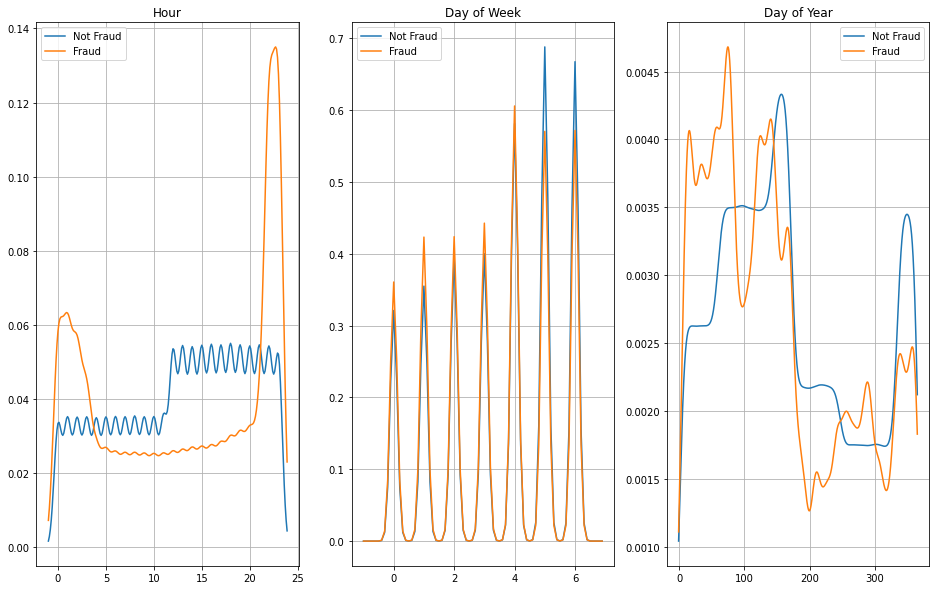

In [10]:
is_fraud = y_train_new == 1
from scipy import stats
plt.figure(figsize=(16, 10))
plt.subplot(1, 3, 1)
dens = stats.kde.gaussian_kde(tester.loc[~is_fraud]['Hour'])
x = np.arange(-1, 24, 0.1)
plt.grid()
plt.plot(x, dens(x), label='Not Fraud')
dens = stats.kde.gaussian_kde(tester.loc[is_fraud]['Hour'])
plt.plot(x, dens(x), label='Fraud')
plt.title('Hour')
plt.legend()

plt.subplot(1, 3, 2)
dens = stats.kde.gaussian_kde(tester.loc[~is_fraud]['day_of_week'])
x = np.arange(-1, 7, 0.1)
plt.grid()
plt.plot(x, dens(x), label='Not Fraud')
dens = stats.kde.gaussian_kde(tester.loc[is_fraud]['day_of_week'])
plt.plot(x, dens(x), label='Fraud')
plt.title('Day of Week')
plt.legend()

plt.subplot(1, 3, 3)
dens = stats.kde.gaussian_kde(tester.loc[~is_fraud]['day_of_year'])
x = np.arange(-1, 365, 0.1)
plt.grid()
plt.plot(x, dens(x), label='Not Fraud')
dens = stats.kde.gaussian_kde(tester.loc[is_fraud]['day_of_year'])
plt.plot(x, dens(x), label='Fraud')
plt.title('Day of Year')
plt.legend()

plt.show()

In [5]:
scores = SelectKBest(mutual_info_classif, k='all')
scores.fit(tester, y_train_new)
temp_df = pd.DataFrame()
temp_df['column'] = tester.columns
temp_df['MI'] = scores.scores_
temp_df

,column,MI
0,unix_time,0.158603
1,day_of_week,0.055638
2,day_of_year,0.053320
3,Hour,0.065778


There is something very interesting about the results above;
The last time we computed the _Mutual Information_ between the target and _unix_time_ the data wasn't balanced and the result was very poor for the feature. 
However, now, when the data is balanced, the result has improved massively, compared to it's last. This suggests that feature might actually be useful.

We also see that the _Hour_ feature resulting not great, but an ok _Mutual Information_ with the target, and we'll try to improve that moving forward.

In [12]:
tester = pd.DataFrame()
tester['unix_time'] = x_train_new['unix_time'].copy()
as_time: pd.Timestamp = pd.to_datetime(x_train_new['unix_time'], unit='s')
tester['hour_minute_sec'] = as_time.apply(lambda x: x.hour) + as_time.apply(lambda x: x.minute/60) + as_time.apply(lambda x: x.second/3600)
tester['hour_minute'] = as_time.apply(lambda x: x.hour) + as_time.apply(lambda x: x.minute/60)
tester['hour'] = as_time.apply(lambda x: x.hour)
tester['minute'] = as_time.apply(lambda x: x.minute)
tester.head()

,unix_time,hour_minute_sec,hour_minute,hour,minute
0,1325376018,0.005000,0.000000,0,0
1,1325376044,0.012222,0.000000,0,0
2,1325376051,0.014167,0.000000,0,0
3,1325376076,0.021111,0.016667,0,1
4,1325376186,0.051667,0.050000,0,3


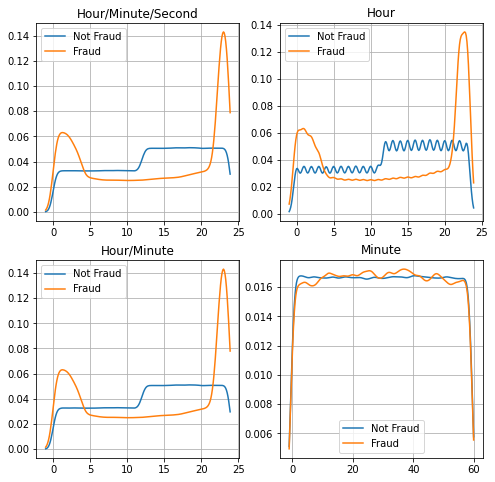

In [13]:
plt.figure(figsize=(8, 8))

x = np.arange(-1, 24, 0.1)

plt.subplot(2, 2, 1)
dens = stats.kde.gaussian_kde(tester.loc[~is_fraud]['hour_minute_sec'])
plt.grid()
plt.plot(x, dens(x), label='Not Fraud')
dens = stats.kde.gaussian_kde(tester.loc[is_fraud]['hour_minute_sec'])
plt.plot(x, dens(x), label='Fraud')
plt.title('Hour/Minute/Second')
plt.legend()

plt.subplot(2, 2, 2)
dens = stats.kde.gaussian_kde(tester.loc[~is_fraud]['hour'])
plt.grid()
plt.plot(x, dens(x), label='Not Fraud')
dens = stats.kde.gaussian_kde(tester.loc[is_fraud]['hour'])
plt.plot(x, dens(x), label='Fraud')
plt.title('Hour')
plt.legend()

plt.subplot(2, 2, 3)
dens = stats.kde.gaussian_kde(tester.loc[~is_fraud]['hour_minute'])
plt.grid()
plt.plot(x, dens(x), label='Not Fraud')
dens = stats.kde.gaussian_kde(tester.loc[is_fraud]['hour_minute'])
plt.plot(x, dens(x), label='Fraud')
plt.title('Hour/Minute')
plt.legend()

plt.subplot(2, 2, 4)
x = np.arange(-1, 60, 0.1)
dens = stats.kde.gaussian_kde(tester.loc[~is_fraud]['minute'])
plt.grid()
plt.plot(x, dens(x), label='Not Fraud')
dens = stats.kde.gaussian_kde(tester.loc[is_fraud]['minute'])
plt.plot(x, dens(x), label='Fraud')
plt.title('Minute')
plt.legend()

plt.show()

Since the visualizations seems to be as informative as the _Mutual Information_ value, we decided to base some of our decisions on the cadidate features's distributions. As could be seen above, the _hour_minute_sec_ value could be really useful to a classification model. 

In [14]:
as_time: pd.Timestamp = pd.to_datetime(x_train_new['unix_time'], unit='s')
x_train_new['hour_minute_sec'] = as_time.apply(lambda x: x.hour) + as_time.apply(lambda x: x.minute/60) + as_time.apply(lambda x: x.second/3600)

Lets see if this feature improves the model:

In [12]:
%%capture
baseline_model_with_hour = cross_validate(make_pipeline(StandardScaler(), LogisticRegression()),  x_train_new.drop(columns=['unix_time'], inplace=False), 
                                          y_train_new, cv=10,  scoring = ('accuracy', 'roc_auc', 'average_precision'))
baseline_model_with_unix = cross_validate(make_pipeline(StandardScaler(), LogisticRegression()),  x_train_new.drop(columns=['hour_minute_sec'], inplace=False), 
                                          y_train_new, cv=10,  scoring = ('accuracy', 'roc_auc', 'average_precision'))

In [13]:
results = {'Logistic Regression With Hour/Minute/Second': [np.mean(baseline_model_with_hour['test_accuracy']), np.mean(baseline_model_with_hour['test_roc_auc']), 
                                   np.mean(baseline_model_with_hour['test_average_precision'])], 
          'Logistic Regression With Unix Time': [np.mean(baseline_model_with_unix['test_accuracy']), np.mean(baseline_model_with_unix['test_roc_auc']), 
                                   np.mean(baseline_model_with_unix['test_average_precision'])]}

baseline_model_with_hour = baseline_model_with_unix = None
pd.DataFrame(results, index=['Accuracy', 'AUC', 'Precision'])

,Logistic Regression With Hour/Minute/Second,Logistic Regression With Unix Time
Accuracy,0.883230,0.879947
AUC,0.917571,0.910776
Precision,0.928227,0.924311


It seems like the _AUC_ and the _Accuracy_ are slightly better with the new feature, hence, we'll keep it.

In [133]:
%%capture
model = cross_validate(make_pipeline(StandardScaler(), LogisticRegression()),  x_train_new, y_train_new, cv=10,  
                       scoring = ('accuracy', 'roc_auc', 'average_precision'))
results = {'Current Model': [np.mean(model['test_accuracy']), np.mean(model['test_roc_auc']), np.mean(model['test_average_precision'])]}

In [ ]:
results = pd.DataFrame(results, index=['Accuracy', 'AUC', 'Precision'])

In [16]:
x_train_new.drop(columns=['unix_time'], inplace=True)
x_train_new.head(3)

,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,city_pop,job,dob,merch_lat,merch_long,hour_minute_sec
0,2703186189652095,514,8,4.97,162,18,0,568,526,27,265,3495,370,779,36.011293,-82.048315,0.005000
1,630423337322,241,4,107.23,309,157,0,435,612,47,965,149,428,607,49.159047,-118.186462,0.012222
2,38859492057661,390,0,220.11,115,381,1,602,468,13,858,4154,307,302,43.150704,-112.154481,0.014167


We'll now try to understand if we could combine the _first_ and _last_ features into one, or maybe simplify the either of them:

In [83]:
tester = pd.DataFrame()
tester['first'] = x_train_new['first']
tester['last'] = x_train_new['last']
f_names = pd.Series(pd.Categorical.from_codes(x_train_new['first'], categories=sorted(x_train['first'].unique()), ordered=False)).to_list()
l_names = pd.Series(pd.Categorical.from_codes(x_train_new['last'], categories=sorted(x_train['last'].unique()), ordered=False)).to_list()
names = [f_names[i] + ' ' + l_names[i] for i in range(len(x_train_new))]
tester['name'] = names.copy()
tester['name'] = tester['name'].astype('category')
names = l_names = f_names = None

In [95]:
tester['first_letter_first_name'] = tester['name'].apply(lambda x: x[0]).astype('category').cat.codes
tester['first_letter_last_name'] = tester['name'].apply(lambda x: x.split(' ')[1][0]).astype('category').cat.codes
tester['length'] = tester['name'].apply(lambda x: len(x))
tester['length_first'] = tester['name'].apply(lambda x: len(x.split(' ')[0]))
tester['length_last'] = tester['name'].apply(lambda x: len(x.split(' ')[1]))
tester['name'] = tester['name'].cat.codes
tester.head()

,first,last,name,first_letter_first_name,first_letter_last_name,length,length_first,length_last
0,162,18,2571,9,1,14,8,5
1,309,157,7446,17,6,14,9,4
2,115,381,1412,4,17,14,6,7
3,163,463,2646,9,20,12,6,5
4,336,149,7983,18,6,12,5,6


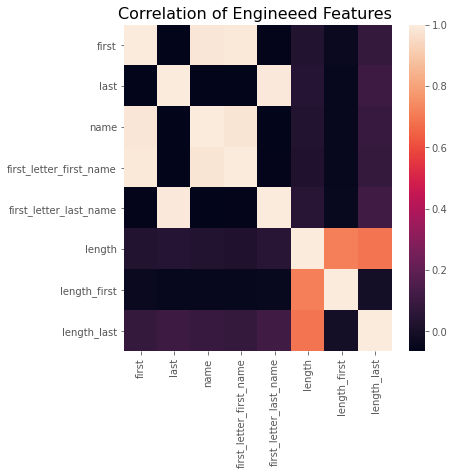

In [98]:
plt.style.use('ggplot')
plt.figure(figsize=(6, 6))
plt.title('Correlation of Engineeed Features ',y=1,size=16)
sns.heatmap(tester.corr(), vmax=1, ax=plt.gca())
plt.show()

In [103]:
tester.drop(columns=['is_fraud', 'length', 'length_last', 'length_first'], inplace=True)
batches = [{'drop': ['last', 'first'], 'add': ['first_letter_last_name', 'name']}, 
          {'drop': ['last', 'first'], 'add': ['first_letter_last_name', 'first_letter_first_name']},
           {'drop': ['last'], 'add': ['first_letter_last_name']},
          {'drop': ['first'], 'add': ['name']},
          {'drop': ['first'], 'add': ['first_letter_first_name']}]

In [ ]:
%%capture

for batch in batches:
    temp_df = x_train_new.copy().drop(columns=batch['drop'])
    name = 'dropped_' + '__'.join(batch['drop']) + '__added__' + '__'.join(batch['add'])
    for c in batch['add']:
        temp_df[c] = tester[c]
    _model = cross_validate(make_pipeline(StandardScaler(), LogisticRegression()), temp_df, y_train_new, cv=10,  
                           scoring = ('accuracy', 'roc_auc', 'average_precision'))
    
    results[name] = [np.mean(_model['test_accuracy']), np.mean(_model['test_roc_auc']), np.mean(_model['test_average_precision'])]

temp_df = _model = None
pd.DataFrame(results, index=['Accuracy', 'AUC', 'Precision'])  

#output was deleted, but the conclusions are below.

None of the new features seem to make any difference, so we'll just keep the old ones.

Next up on the line, is the _category_ feature. We might be able to squeeze some more information out of this feature.


In [161]:
tester = pd.DataFrame()
tester['category'] = pd.Series(pd.Categorical.from_codes(x_train_new['category'], categories=sorted(x_train['category'].unique()), ordered=False)).to_list()
tester['sub_category_1'] = tester['category'].apply(lambda x: x if len(x.split('_')) == 0 else x.split('_')[-1]).astype('category').cat.codes
tester['sub_category_2'] = tester['category'].apply(lambda x: x.split('_')[0]).astype('category').cat.codes
tester['category'] = x_train_new['category']
tester['is_fraud'] = y_train_new
tester.head()

,category,sub_category_1,sub_category_2,is_fraud
0,8,5,7,0
1,4,7,3,0
2,0,2,0,0
3,2,8,2,0
4,9,7,7,0


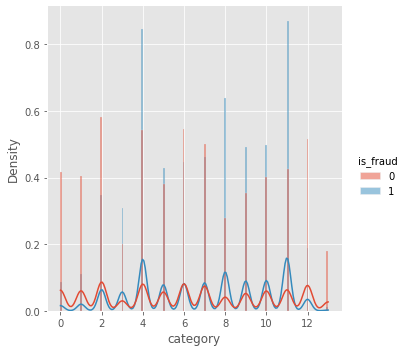

In [156]:
sns.displot(tester, x='category', hue='is_fraud', kde=True, stat='density')

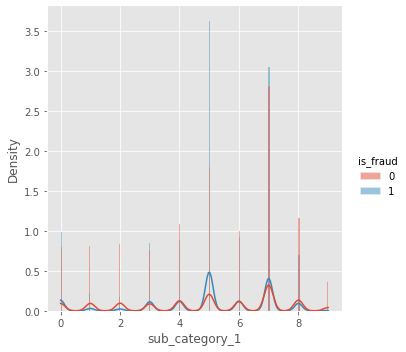

In [157]:
sns.displot(tester, x='sub_category_1', hue='is_fraud', kde=True, stat='density')

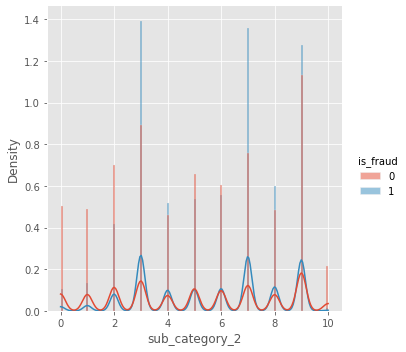

In [158]:
sns.displot(tester, x='sub_category_2', hue='is_fraud', kde=True, stat='density')

In [162]:
tester.corr()

,category,sub_category_1,sub_category_2,is_fraud
category,1.000000,0.064687,0.993974,0.097426
sub_category_1,0.064687,1.000000,0.051546,0.019631
sub_category_2,0.993974,0.051546,1.000000,0.111248
is_fraud,0.097426,0.019631,0.111248,1.000000


In [170]:
%%capture

for c in ['sub_category_1', 'sub_category_2']:
    temp_df = x_train_new.drop(columns=['category'], inplace=False).copy()
    temp_df[c] = tester[c]
    _model = cross_validate(make_pipeline(StandardScaler(), LogisticRegression()),  temp_df, y_train_new, cv=10,  
                            scoring = ('accuracy', 'roc_auc', 'average_precision'))

    results['New_Model_' + c] = [np.mean(_model['test_accuracy']), np.mean(_model['test_roc_auc']), np.mean(_model['test_average_precision'])]


In [171]:
results

,Current Model,New_Model_sub_category_1,New_Model_sub_category_2
Accuracy,0.883230,0.880173,0.882097
AUC,0.917571,0.918599,0.916691
Precision,0.928227,0.927114,0.927534


The _sub_category_1_ feature isnt correlated at all with the original one, thus, we could try them together on the model.

In [172]:
%%capture
temp_df = x_train_new.copy()
temp_df['sub_category_1'] = tester['sub_category_1']
_model = cross_validate(make_pipeline(StandardScaler(), LogisticRegression()),  temp_df, y_train_new, cv=10,  
                        scoring = ('accuracy', 'roc_auc', 'average_precision'))

results['Last_of_Category'] = [np.mean(_model['test_accuracy']), np.mean(_model['test_roc_auc']), np.mean(_model['test_average_precision'])]


In [173]:
temp_df = _model = None
results

,Current Model,New_Model_sub_category_1,New_Model_sub_category_2,Last_of_Category
Accuracy,0.883230,0.880173,0.882097,0.882517
AUC,0.917571,0.918599,0.916691,0.922830
Precision,0.928227,0.927114,0.927534,0.930075


The results has quite improved, so we should keep this feature.

In [174]:
results['Current Model'] = results['Last_of_Category']
results.drop(columns=['New_Model_sub_category_1', 'New_Model_sub_category_2', 'Last_of_Category'], inplace=True)

In [189]:
x_train_new['sub_category'] = tester['sub_category_1']

As for the last feature, we'll try to work on _street_ feature:

In [201]:
tester = pd.DataFrame()
tester['street_number'] = pd.Series(pd.Categorical.from_codes(x_train_new['street'], categories=sorted(x_train['street'].unique()), ordered=False)).apply(lambda z: int(z.split(' ')[0]))
tester['street_name'] = pd.Series(pd.Categorical.from_codes(x_train_new['street'], categories=sorted(x_train['street'].unique()), ordered=False)).apply(lambda z: ' '.join(z.split(' ')[1:]))
tester['street_name'] = tester['street_name'].astype('category').cat.codes

In [207]:
%%capture

for c in ['street_name', 'street_number', ['street_name', 'street_number']]:
    temp_df = x_train_new.drop(columns=['street'], inplace=False).copy()
    temp_df[c] = tester[c]
    _model = cross_validate(make_pipeline(StandardScaler(), LogisticRegression()),  temp_df, y_train_new, cv=10,  
                            scoring = ('accuracy', 'roc_auc', 'average_precision'))
    
    name = 'New_Model_' + c if type(c) == 'str' else 'New_Model_' + c[0] + '__' + c[1]
    results[name] = [np.mean(_model['test_accuracy']), np.mean(_model['test_roc_auc']), np.mean(_model['test_average_precision'])]

temp_df = _model = None

In [209]:
results

,Current Model,New_Model_s__t,New_Model_street_name__street_number
Accuracy,0.882517,0.88255,0.882542
AUC,0.922830,0.92287,0.922882
Precision,0.930075,0.93011,0.930115


Both new features are good enough to replace the old one.

In [212]:
x_train_new['street_number'] = pd.Series(pd.Categorical.from_codes(x_train_new['street'], categories=sorted(x_train['street'].unique()), ordered=False)).apply(lambda z: int(z.split(' ')[0]))
x_train_new['street_name'] = pd.Series(pd.Categorical.from_codes(x_train_new['street'], categories=sorted(x_train['street'].unique()), ordered=False)).apply(lambda z: ' '.join(z.split(' ')[1:]))
x_train_new['street_name'] = x_train_new['street_name'].astype('category').cat.codes
tester = None

## Task 4 Any model
Use any classification model we discussed (trees, forests, boosting, SVM) to improve your result. You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models. Tune parameters as appropriate

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
# Pick up from last point of pre processing (should be used for the final product):

one_hotted = one_hotted = ['gender', 'sub_category', 'category']
def preProcess(x_df: pd.DataFrame, y_df, encode=False) -> pd.DataFrame:
    x = x_df.copy()

    as_time = pd.to_datetime(x['unix_time'], unit='s')

    x['zip'] = x['zip'].astype(object)
    x['hour_minute_sec'] = as_time.apply(lambda z: z.hour) + as_time.apply(lambda z: z.minute/60) + as_time.apply(lambda z: z.second/3600)
    x['sub_category'] = x['category'].apply(lambda z: z if len(z.split('_')) == 0 else z.split('_')[-1])
    x['street_name'] = x['street'].apply(lambda z: ' '.join(z.split(' ')[1:]))
    x['street_number'] = x['street'].apply(lambda z: int(z.split(' ')[0]))
    x.drop(columns=['street'], inplace=True)
    
    credit_cards = pd.DataFrame()
    credit_cards['cc_num'] = x['cc_num'].copy()
    
    credit_cards['unix_time'] = x['unix_time']
    credit_cards = credit_cards.iloc[np.argsort(credit_cards['unix_time'])]
    
    credit_cards['diff'] = credit_cards.groupby(by=['cc_num']).diff()['unix_time']
    is_nan = credit_cards.isna()['diff']
    credit_cards.fillna(value=0, inplace=True)
    credit_cards['time_diff'] = pd.to_datetime(credit_cards['diff'], unit='s')
    credit_cards['time_diff'] = credit_cards['time_diff'].apply(lambda z: z.day + z.hour/24 + z.minute/(24*60) + z.second/(24*3600))
    credit_cards.loc[is_nan] = 0
    
    x['time_diff'] = credit_cards['time_diff'].copy()
    x['job'] = x['job'].apply(lambda _x: _x.split(',')[0])
    
    credit_cards = None
    x = x.drop(columns=['unix_time'], inplace=False)

    categorical = x.dtypes == object
    x.loc[:, categorical] = x.loc[:, categorical].apply(lambda z: z.astype('category'))
    
    def featureEnhancement(_x: pd.DataFrame, _y: pd.DataFrame):
        is_fraud = _y == 1
        dangures_streets_names = []
    
        uniqes_fraud_streets = _x.loc[is_fraud]['street_name'].value_counts().where(lambda __x : __x > 0).dropna()
        uniqes_legit_streets = _x.loc[~is_fraud]['street_name'].value_counts().where(lambda __x : __x > 0).dropna()

        uniqe_diff = len(uniqes_fraud_streets) / len(uniqes_legit_streets)
        upper_bound = int(uniqe_diff * len(uniqes_legit_streets))
        uniqes_fraud_precentail = 0.20

        most_dangures_streets = uniqes_fraud_streets.head(int(uniqes_fraud_precentail * len(uniqes_fraud_streets)))
        most_popular_streets = uniqes_legit_streets.head(upper_bound)
    
        for index in most_dangures_streets.index:
            if (index not in most_popular_streets.index):
                dangures_streets_names.append(index)
            
        dangures_streets_names
        _x['dangerous_street'] = _x['street_name'].apply(lambda z: 1 if z in dangures_streets_names else 0)
        return _x
    
    x = featureEnhancement(x.copy(), y_df.copy())
    categorical = x.dtypes == 'category'
    
    if encode:
        one_categorical = np.array([c in one_hotted for c in x.columns])
        x.loc[:, ~one_categorical & categorical] = x.loc[:, ~one_categorical & categorical].apply(lambda z: z.cat.codes)
        dummies = pd.get_dummies(x.loc[:, one_categorical])
        x.drop(columns=one_hotted, inplace=True)
        x.loc[:, dummies.columns] = dummies
        
    
    return x

In [2]:
%%time
x_train = pd.read_csv('fraudTrain.csv', index_col=0)
y_train = x_train['is_fraud']
x_train.drop(columns=['is_fraud', 'long', 'lat', 'trans_num', 'trans_date_trans_time'], inplace=True)

x_train = preProcess(x_train, y_train)

categorical = x_train.dtypes == 'category'
one_categorical = np.array([c in one_hotted for c in x_train.columns])
temp_df = x_train.copy()
temp_df.loc[:, ~one_categorical & categorical] = temp_df.loc[:, ~one_categorical & categorical].apply(lambda _x: _x.cat.codes)
dummies = pd.get_dummies(temp_df.loc[:, one_categorical])
temp_df.drop(columns=one_hotted, inplace=True)
temp_df.loc[:, dummies.columns] = dummies

x_train_new, y_train_new = SMOTE().fit_resample(temp_df, y_train)
temp_df = dummies = None

c:\Users\tomda\source\pytho\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Wall time: 57.6 s


In [55]:
x_train.head(3)

,cc_num,merchant,category,amt,first,last,gender,city,state,zip,...,job,dob,merch_lat,merch_long,hour_minute_sec,sub_category,street_name,street_number,time_diff,dangerous_street
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,Moravian Falls,NC,28654,...,Psychologist,1988-03-09,36.011293,-82.048315,0.005000,net,Perry Cove,561,0.0,0
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,Orient,WA,99160,...,Special educational needs teacher,1978-06-21,49.159047,-118.186462,0.012222,pos,Riley Greens Suite 393,43039,0.0,0
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,Malad City,ID,83252,...,Nature conservation officer,1962-01-19,43.150704,-112.154481,0.014167,entertainment,White Dale Suite 530,594,0.0,0


In [56]:
x_train_new.head(3)

,cc_num,merchant,amt,first,last,city,state,zip,city_pop,job,...,sub_category_care,sub_category_dining,sub_category_entertainment,sub_category_fitness,sub_category_home,sub_category_net,sub_category_pets,sub_category_pos,sub_category_transport,sub_category_travel
0,2703186189652095,514,4.97,162,18,526,27,265,3495,318,...,0,0,0,0,0,1,0,0,0,0
1,630423337322,241,107.23,309,157,612,47,965,149,363,...,0,0,0,0,0,0,0,1,0,0
2,38859492057661,390,220.11,115,381,468,13,858,4154,261,...,0,0,1,0,0,0,0,0,0,0


In [3]:
%%time
x_test = pd.read_csv('fraudTest.csv', index_col=0)
y_test = x_test['is_fraud']
x_test.drop(columns=['is_fraud', 'long', 'lat', 'trans_num', 'trans_date_trans_time'], inplace=True)

x_test = preProcess(x_test, y_test, encode=True)

Wall time: 23.5 s


In [61]:
x_test.head(3)

,cc_num,merchant,amt,first,last,city,state,zip,city_pop,job,...,sub_category_care,sub_category_dining,sub_category_entertainment,sub_category_fitness,sub_category_home,sub_category_net,sub_category_pets,sub_category_pos,sub_category_transport,sub_category_travel
0,2291163933867244,319,2.86,151,115,157,39,254,333497,230,...,1,0,0,0,0,0,0,0,0,0
1,3573030041201292,591,29.84,163,457,16,43,811,302,336,...,1,0,0,0,0,0,0,0,0,0
2,3598215285024754,611,41.28,24,249,61,33,69,34496,214,...,0,0,0,1,0,0,0,0,0,0


In [4]:
%%time
baseline_model = make_pipeline(StandardScaler(), LogisticRegression()).fit(x_train_new, y_train_new)

Wall time: 1min 20s


c:\Users\tomda\source\pytho\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [5]:
baseline_model.score(x_test, y_test)

0.9860019182356551

In [6]:
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve, plot_confusion_matrix
print(classification_report(y_test, baseline_model.predict(x_test), target_names=['Clear','Fraud']))
print(f'AUC = {roc_auc_score(y_test, baseline_model.predict(x_test))}')

              precision    recall  f1-score   support

       Clear       1.00      0.99      0.99    553574
       Fraud       0.18      0.72      0.28      2145

    accuracy                           0.99    555719
   macro avg       0.59      0.85      0.64    555719
weighted avg       1.00      0.99      0.99    555719

AUC = 0.8520302531152029


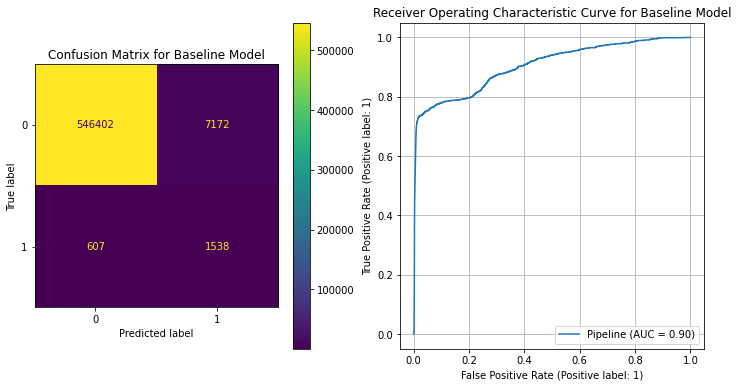

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Confusion Matrix for Baseline Model')
plot_confusion_matrix(baseline_model, x_test, y_test, ax=plt.gca())
plt.subplot(1, 2, 2)
plt.grid()
plt.title('Receiver Operating Characteristic Curve for Baseline Model')
plot_roc_curve(baseline_model, x_test, y_test, ax=plt.gca())
plt.show()

#### Midway summary:
We chose Logistic Regression as our baseline model (with data scaling). This pipline is doing an "OK" job with the data classification, but we obviously would like a model that can do better. Thus, we'll try out some other classification models.

### Gradient Boosting:

In [ ]:
#!pip install xgboost
#!pip install tune-sklearn
#!pip install dask-ml

In [8]:
N = np.append(np.arange(0, 30 * 10 ** 3), np.arange(len(y_train_new) - 30 * 10 ** 3, len(y_train_new)))
print(np.unique(y_train_new[N], return_counts=True))

(array([0, 1], dtype=int64), array([29712, 30288], dtype=int64))


In [ ]:
%%time
from dask.distributed import Client
import joblib
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier as GBC
client = Client(processes=False)

param_space = {
    'model__learning_rate': np.logspace(-6, 1, 10),
    'model__n_estimators': [90, 100, 110, 120],
    'model__loss': ['deviance', 'exponential'],
    
}
model = Pipeline(steps=[('scaler', StandardScaler()), ('model', GBC(verbose=True, n_iter_no_change=5, tol=0.001))])
model = GridSearchCV(model, param_grid=param_space, cv=3, return_train_score=True, verbose=10)

with joblib.parallel_backend('dask'):
    model.fit(x_train_new.iloc[N, :], y_train_new[N])
    
client.close()

In [69]:
model.best_score_

0.9908

In [79]:
%%time
model = model.best_estimator_
client = Client(processes=False)
with joblib.parallel_backend('dask'):
    model = model.fit(x_train_new, y_train_new)

c:\Users\tomda\source\pytho\lib\site-packages\distributed\node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 5108 instead
  http_address["port"], self.http_server.port


      Iter       Train Loss   Remaining Time 
         1           1.0735           61.79m
         2           0.8923           57.31m
         3           0.7793           54.01m
         4           0.6969           52.99m
         5           0.6429           51.69m
         6           0.6002           51.72m
         7           0.5719           50.83m
         8           0.5467           50.01m
         9           0.5258           49.52m
        10           0.5061           48.75m
        20           0.3681           43.89m
        30           0.2812           39.27m
        40           0.2233           35.28m
        50           0.1821           30.73m
        60           0.1488           26.12m
        70           0.1245           21.62m
        80           0.1063           17.23m
        90           0.0932           13.04m
       100           0.0827            8.70m
Wall time: 52min 14s


In [86]:
print(f'score = {model.score(x_test, y_test)}')
model

score = 0.9934409296784886


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.2782559402207126,
                                            n_estimators=120,
                                            n_iter_no_change=5, tol=0.001,
                                            verbose=True))])

In [83]:
#joblib.dump(model, 'GBC.pkl')
#
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve, plot_confusion_matrix
print(classification_report(y_test, model.predict(x_test), target_names=['Clear','Fraud']))
print(f'AUC = {roc_auc_score(y_test, model.predict(x_test))}')

              precision    recall  f1-score   support

       Clear       1.00      0.99      1.00    553574
       Fraud       0.36      0.91      0.52      2145

    accuracy                           0.99    555719
   macro avg       0.68      0.95      0.76    555719
weighted avg       1.00      0.99      0.99    555719

AUC = 0.9507327489535828


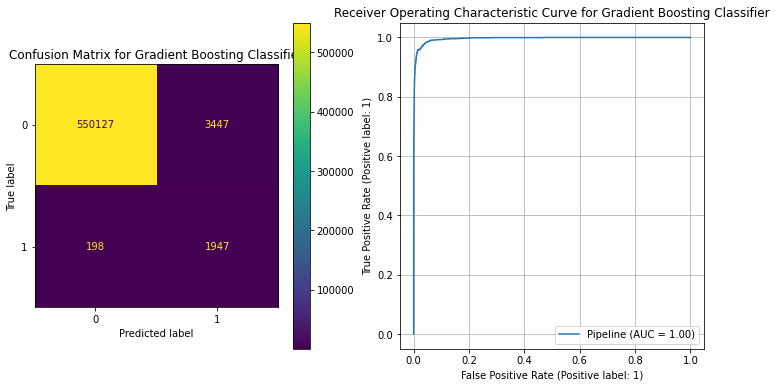

In [85]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Confusion Matrix for Gradient Boosting Classifier')
plot_confusion_matrix(model, x_test, y_test, ax=plt.gca())
plt.subplot(1, 2, 2)
plt.grid()
plt.title('Receiver Operating Characteristic Curve for Gradient Boosting Classifier')
plot_roc_curve(model, x_test, y_test, ax=plt.gca())
plt.show()

In [95]:
print('Feature importance:')
{c:i for c, i in zip(x_train_new,model.steps[1][1].feature_importances_)}

Feature importance:


{'cc_num': 7.782392635943769e-05,
 'merchant': 0.0,
 'amt': 0.7751270389337528,
 'first': 7.280378907375774e-05,
 'last': 9.055740622349837e-05,
 'city': 0.00012678840537999278,
 'state': 5.681893815523348e-05,
 'zip': 3.68486640120878e-05,
 'city_pop': 0.000216410792952557,
 'job': 0.00014643619746408667,
 'dob': 0.0006966262799325719,
 'merch_lat': 0.00010444904848610424,
 'merch_long': 0.00013641511718140477,
 'hour_minute_sec': 0.023167604440658626,
 'street_name': 8.863867136173948e-05,
 'street_number': 1.3986621417215577e-05,
 'time_diff': 0.007137722127907179,
 'dangerous_street': 0.0034858427036275506,
 'category_entertainment': 0.007165776212315418,
 'category_food_dining': 0.005194860025863803,
 'category_gas_transport': 0.014353147852998505,
 'category_grocery_net': 0.0008630318543507043,
 'category_grocery_pos': 0.007050323987288882,
 'category_health_fitness': 0.0067535935716951535,
 'category_home': 0.0049691946960764575,
 'category_kids_pets': 0.007788619401632563,
 'ca

### XGBoost Classifier:

In [10]:
from sklearn.calibration import CalibratedClassifierCV
from xgboost.sklearn import XGBClassifier as XGB
from dask.distributed import Client
import joblib
from sklearn.model_selection import GridSearchCV

In [ ]:
%%time
client = Client(processes=False)

param_space = {
    'model__booster': ['gbtree', 'gblinear', 'dart'],
    'model__n_estimators': [80, 100, 120],
    'model__learning_rate': np.logspace(-4, -1, 4),
    'model__reg_alpha': np.array([10**-4, 10**-2, 1, 100]),
    'model__reg_lambda': np.array([10**-4, 10**-2, 1, 100])
}
model = Pipeline(steps=[('scaler', StandardScaler()), ('model', XGB(verbosity=3, objective='binary:logistic', gamma=0.001, tree_method='hist'))])
model = GridSearchCV(model, param_grid=param_space, cv=3, return_train_score=True, verbose=10)

with joblib.parallel_backend('dask'):
    model.fit(x_train_new.iloc[N, :], y_train_new[N])
    
client.close()

In [19]:
model.best_score_

0.9912333333333333

In [28]:
model.best_estimator_.steps[1][1]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=120, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0.01, reg_lambda=0.0001, scale_pos_weight=1,
              subsample=1, tree_method='hist', validate_parameters=1,
              verbosity=3)

In [58]:
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve, plot_confusion_matrix
print(classification_report(y_test, model.best_estimator_.predict(x_test), target_names=['Clear','Fraud']))
print(f'AUC = {roc_auc_score(y_test, model.best_estimator_.predict(x_test))}')

c:\Users\tomda\source\pytho\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


              precision    recall  f1-score   support

       Clear       1.00      0.99      1.00    553574
       Fraud       0.31      0.91      0.46      2145

    accuracy                           0.99    555719
   macro avg       0.65      0.95      0.73    555719
weighted avg       1.00      0.99      0.99    555719



c:\Users\tomda\source\pytho\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


AUC = 0.9533847402439496


The results seem pretty similar to the Gradient Boosting model. Let's try to enhance them, using model calibration:

In [54]:
y_prob = model.best_estimator_.predict_proba(x_test)

In [59]:
xgb_model = XGB(objective='binary:logistic', gamma=0.001, tree_method='hist', booster = 'gbtree', learning_rate=0.1, 
                reg_alpha=0.01, reg_lambda=0.0001, n_estimators=120)
x1, x2, y1, y2 = train_test_split(x_train_new, y_train_new, shuffle=True, test_size=0.5)
xgb_model = make_pipeline(StandardScaler(), xgb_model).fit(x1, y1)
model = CalibratedClassifierCV(xgb_model, method='isotonic', cv='prefit').fit(x2, y2)

[19:19:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.


c:\Users\tomda\source\pytho\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


CalibratedClassifierCV(base_estimator=Pipeline(steps=[('standardscaler',
                                                       StandardScaler()),
                                                      ('xgbclassifier',
                                                       XGBClassifier(base_score=0.5,
                                                                     booster='gbtree',
                                                                     colsample_bylevel=1,
                                                                     colsample_bynode=1,
                                                                     colsample_bytree=1,
                                                                     gamma=0.001,
                                                                     gpu_id=-1,
                                                                     importance_type='gain',
                                                                     interaction_const

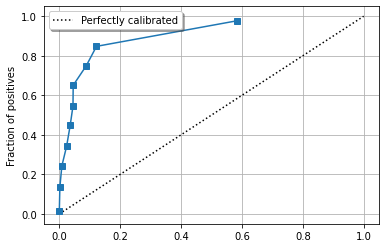

In [55]:
from sklearn.calibration import calibration_curve

curve = calibration_curve(y_true=y_test, y_prob=y_prob[:, 1], n_bins=10)
plt.grid()
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(curve[0], curve[1], "s-")
plt.ylabel("Fraction of positives")
plt.legend(shadow=True, fancybox=True)

In [ ]:
#joblib.dump(model.best_estimator_, 'XGB.pkl')

## Task 5 Feature Selections
Identify features that are important for your best model. Which features are most influential,and which features could be removed without decrease in performance? Does removing irrelevant features make your model better?

## Task 6 An explainable model
Can you create an “explainable” model that is nearly as good as your best model? An explainable model should be small enough to be easily inspected - say a linear model withfew enough coefficients that you can reasonable look at all of them, or a tree with a smallnumber of leafs etc.